# CS345 Final Project: Using Machine Learning on Windows Portable Eecutable Files
By Jack Adams

Github: https://github.com/free-belgian-waffles/CS3450-Project

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

## Introduction
With computers getting easier and easier to use, the need for speedy malware detection and analysis is higher than ever. A common way which bad actors will target a system is by using Windows Portable Executable (PE) files. Windows PE files are essentially executable files which are wrapped in a single file in order to be executed on any system, which makes it very easy for bad actors to sneak malware into these files. This report looks at using different machine learning techniques in order to analyze a dataset of known Windows PE Malware, and comparing the results of these different predictive models to see how accurate and fast they are

The dataset I will be using in this report is the SOMLAP Portable Executable Malware which is made up of a wide array of Windows PE sample files.
The dataset and more information can be found here:
- https://www.kaggle.com/datasets/ravikiranvarmap/somlap-data-set
- Kattamuri, Santosh Jhansi, Ravi Kiran Varma Penmatsa, Sujata Chakravarty, and Venkata Sai Pavan Madabathula. 2023. "Swarm Optimization and Machine Learning Applied to PE Malware Detection towards Cyber Threat Intelligence" Electronics 12, no. 2: 342. https://doi.org/10.3390/electronics12020342


## Exploring the Data
To start this project, I'll show some general information about the dataset which could be useful for later classification

In [8]:
url = 'https://raw.githubusercontent.com/free-belgian-waffles/CS3450-Project/main/SOMLAP%20DATASET(1).csv'

somlap = pd.read_csv(url)

somlap.head()

,blp,Fp,Rn,Prhdr,Minpar,Maxpar,Ivalss,Ivalsp,doscksum,Iip,...,bss_viraddr,bss_datsize,bss_ptrrawdat,bss_char,bss_entro,bss_phyaddr.1,bss_virsize.1,bss_viraddr.1,bss_char.1,class
0,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
1,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
2,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
3,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0
4,144,3,0,4,0,65535,0,184,0,0,...,0,0,0,0,0.0,0,0,0,0,0


In [9]:
print(somlap.shape)
print(somlap.columns)
somlap['class'].value_counts()

(51408, 109)
Index(['blp', 'Fp', 'Rn', 'Prhdr', 'Minpar', 'Maxpar', 'Ivalss', 'Ivalsp',
       'doscksum', 'Iip',
       ...
       'bss_viraddr', 'bss_datsize', 'bss_ptrrawdat', 'bss_char', 'bss_entro',
       'bss_phyaddr.1', 'bss_virsize.1', 'bss_viraddr.1', 'bss_char.1',
       'class'],
      dtype='object', length=109)


class
0    31600
1    19808
Name: count, dtype: int64

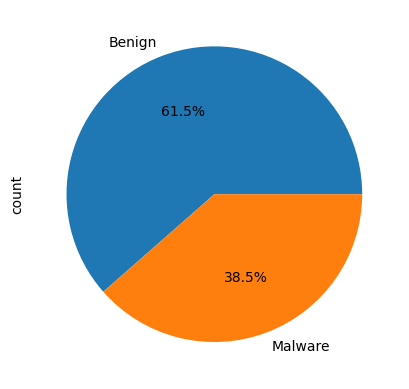

In [10]:
somlap['class'].value_counts().plot(kind="pie",autopct="%1.1f%%", labels=['Benign', 'Malware'])
plt.show()

The SOMLAP dataset has a total of 51,408 samples, with 31,600 of them being Benign and the remaining 19,808 being Malware
This quick look into the dataset seems to reveal three things:
1. Some of the features' values in the dataset are much larger than others, which implies that this dataset could be improved with standardization
2. The dataset has 108 features which means that it has a very high dimensional space and could benefit from reducing the dimensionality using PCA.
3. The benign to malware ration shows that the dataset is unbalanced and could lead to classifers having a bias towards the benign samples

## Linearly Separable
If we want to compute SVC performance, it will be a good idea to check if the dataset is linearly seperable by using PCA to reduce the dimensionality of the dataset (as mentioned in bullet 2 above).

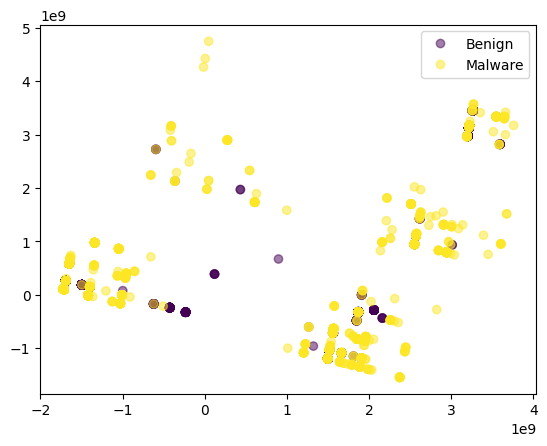

In [12]:
X_somlap = somlap.drop('class', axis=1).values
y_somlap = somlap['class'].values

n_components = 10
X_somlap_reduced = PCA(n_components=n_components).fit_transform(X_somlap)
scatter = plt.scatter(X_somlap_reduced[:, 0], X_somlap_reduced[:, 1], alpha=0.5, c=y_somlap)
plt.legend(handles=scatter.legend_elements()[0], labels=['Benign', 'Malware'])
plt.show()

This graph shows us that the data in the SOMLAP dataset is in face not linearly seperable, thus we are able to exclude the use of a linear kernel from our baseline computation.

## Baselining

In [16]:
def take_baselines(X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    for kernel in ['poly', 'rbf', 'sigmoid']:
        classifier = SVC(kernel=kernel, class_weight='balanced')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy = balanced_accuracy_score(y_test, y_pred)

        print(f'{kernel} kernel accuracy: {accuracy}')



In [18]:
%timeit -r 1 -n 1 take_baselines(X_somlap, y_somlap)

poly kernel accuracy: 0.8968690040118612
rbf kernel accuracy: 0.9034585344109154
sigmoid kernel accuracy: 0.8410614958234006
3min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Standardization
As shown in the above results, the RBF kernel will provide us with the highest accuracy. As stated in bullet 1, some of the features' values are very large, and so we will now see how Standardization will improve the dataset's accuracy.

In [19]:
X_somlap_std = StandardScaler().fit_transform(X_somlap)

def evaluate_classifier(classifier, X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred)}')

svc = SVC(kernel='rbf', class_weight='balanced')
%timeit -r 1 -n 1 evaluate_classifier(svc, X_somlap_std, y_somlap)

Accuracy: 0.9632100703529275
32.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Computational Time Reduction and Accuracy Improvement
While the standardization yields a better performance, we would still want to reduce the dimensionality of the SOMLAP dataset. The reasoning for this is due to the fact that running SVC is computationally expensive when run on large datasets like SOMLAP. Reducing the dimensionality will greatly improve the performance and computational time of SVC.

{2: 0.841066341066341, 10: 0.9275345465821656, 25: 0.9530447506637982, 50: 0.9615239258096402, 75: 0.9634474872570111, 108: 0.9636509874605113}


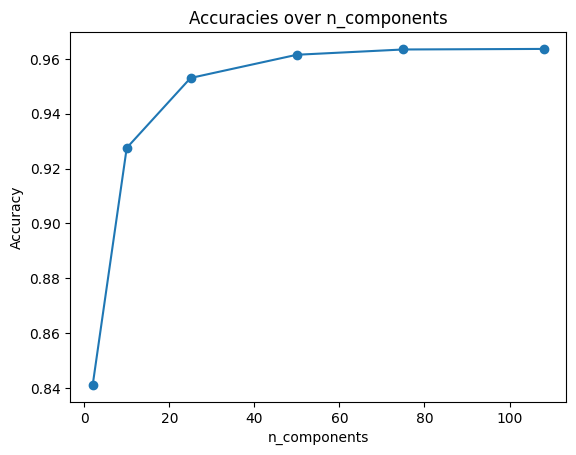

In [20]:
def make_pipeline(n_components, kernel='rbf'):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('svc', SVC(kernel=kernel, class_weight='balanced'))
    ])

def plot_parameters_accuracy(results):
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.title('Accuracies over n_components')
    plt.xlabel('n_components')
    plt.ylabel('Accuracy')
    plt.show()

def compute_svc_with_pca(X, y, test_size=0.25, random_state=42):
    n_components_list = [2, 10, 25, 50, 75, 108]
    results = {}
    for n_components in n_components_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        classifier = make_pipeline(n_components)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = balanced_accuracy_score(y_test, y_pred)

        results[n_components] = accuracy

    print(results)
    plot_parameters_accuracy(results)

compute_svc_with_pca(X_somlap, y_somlap)

Running SVC with PCA shows us that the accurracy seems to plateau around the 50 components mark on the graph. This number will be used in future operations since the change in accuracy above 50 is negligable. Using 50, we will now look to see if this makes the individual execution time improve.

In [21]:
classifier = make_pipeline(50)
%timeit -r 1 -n 1 evaluate_classifier(classifier, X_somlap_std, y_somlap)

Accuracy: 0.962178033606605
19.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Using Bagging is another potential way to reduce the computation time for our dataset. The BaggingClassifier has a few key parameters, being max_samples, max_features, and n_jobs. Max_samples dictates which subset of samples will be used, max_features dictates the subset of features, and n_jobs is a parameter which will dictate running in parallel.

{0.25: 0.9569790879314689, 0.5: 0.9613882590073066, 0.75: 0.9628369866465105}


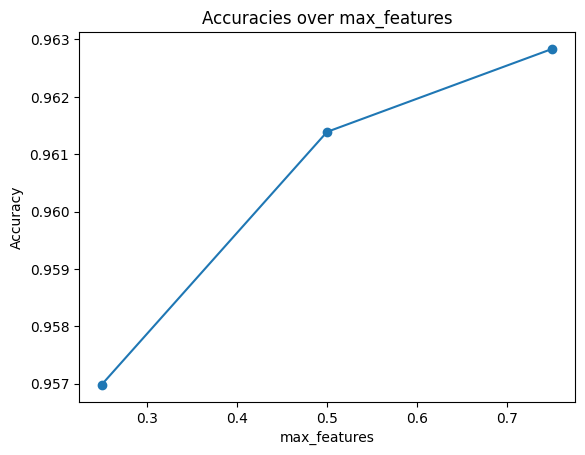

In [22]:
def make_pipeline_bagging(max_samples, max_features, n_components=50, random_state=42, kernel='rbf', n_jobs=3):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', BaggingClassifier(estimator=SVC(kernel=kernel, class_weight='balanced'), max_samples=max_samples,
                                          max_features=max_features, random_state=random_state, n_jobs=n_jobs))
    ])

def plot_parameters_accuracy(results):
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.title('Accuracies over max_features')
    plt.xlabel('max_features')
    plt.ylabel('Accuracy')
    plt.show()
    
def compute_bagging(X, y, max_features=0.5, test_size=0.25, random_state=42):
    max_samples_features_list = [(0.25, max_features), (0.5, max_features), (0.75, max_features)]
    results = {}
    for max_samples, max_features in max_samples_features_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        classifier = make_pipeline_bagging(max_samples, max_features)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = balanced_accuracy_score(y_test, y_pred)

        results[max_samples] = accuracy


    print(results)
    plot_parameters_accuracy(results)

compute_bagging(X_somlap, y_somlap)

By using 50% of both the samples and features of the dataset, we get an accuracy which is close enough to the one we got when using PCA. With these results we can now check if the execution time is better when we use bagging.

In [23]:
classifier = make_pipeline_bagging(0.5, 0.5)
%timeit -r 1 -n 1 evaluate_classifier(classifier, X_somlap_std, y_somlap)

Accuracy: 0.9613882590073066
30 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Unfortunately bagging does not seem to make any improvement to the execution time over PCA. This is likely because bagging requires a larger subset of SOMLAP's samples in order to obtain an accuracy which is close to that of SVC, but with a far worse execution time.

## SVC Hyperparameters, Random Forests, and Gradient Boosting
Now that we have our SVC performance, we can use Random Forests, Gradient Boosting, and Histogram Gradient Boosting and compare the SVC performance.
- Random Forest uses multiple decision trees on different subsets of the data and merges them together.
- Gradient Boosting makes a sequence of decision trees with each tree containing the errors of the previous ones.
- Histogram Gradient Boosting is a different type of Gradient Boosting which uses histograms during the splitting process, which reduces computation cost and is great for use on large datasets like ours.

Each different type mentioned above are both computationally fast and very accurate. Because of this we should first try and maximize the accuracy of the SVC by computing the best hyperparameters using train, validation, and test splits.

In [24]:
def three_way_split(X, y, r_train=0.5, r_valid=0.25, r_test=0.25, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = r_test, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size = r_valid / (r_train + r_valid), random_state=42)
    return X_train, y_train, X_valid, y_valid, X_test, y_test


def optimal_hyperparameter(classifier, C, gamma, C_values, gamma_values,
                           X_train, X_valid, y_train, y_valid):
    optimal_accuracy = 0
    optimal_C = None
    optimal_gamma = None
    for C_value in C_values:
        for gamma_value in gamma_values:
            param_dict = {C : C_value, gamma: gamma_value}
            classifier.set_params(**param_dict)
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_valid)
            current_accuracy = balanced_accuracy_score(y_valid, y_pred)

            if current_accuracy > optimal_accuracy:
                optimal_accuracy = current_accuracy
                optimal_C = C_value
                optimal_gamma = gamma_value
    return optimal_C, optimal_gamma


def evaluate_svc(classifier, X, y, C_values, gamma_values, r_train=0.5, r_valid=0.25, r_test=0.25, 
                 C='svc__C', gamma='svc__gamma'):
    X_train, y_train, X_valid, y_valid, X_test, y_test = three_way_split(X, y)

    C_value, gamma_value = optimal_hyperparameter(classifier, C, gamma, C_values, gamma_values, X_train, X_valid, y_train, y_valid)

    param_dict = {C : C_value, gamma: gamma_value}
    classifier.set_params(**param_dict)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print(f'Accuracy {balanced_accuracy_score(y_test, y_pred)} with C {C_value} and gamma {gamma_value}')

### Hyperparameter Selection With SVC

In [25]:
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf', class_weight='balanced'))
])

gamma_values = [0.001, 1.0, 10.0]
C_values = [10, 100, 1000]

%timeit -r 1 -n 1 evaluate_svc(classifier, X_somlap, y_somlap, C_values, gamma_values)

Accuracy 0.9754588445064636 with C 1000 and gamma 1.0
5min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Random Forest Classification

In [26]:
random_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(n_estimators=100, max_samples=0.25,
                                             random_state=42, class_weight='balanced', n_jobs=3))
])
%timeit -r 1 -n 1 evaluate_classifier(random_forest, X_somlap, y_somlap)

Accuracy: 0.9929743977363026
775 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Gradient Boosting Using Classification

In [27]:
gradient_boosting = Pipeline([
    ('scaler', StandardScaler()),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

%timeit -r 1 -n 1 evaluate_classifier(gradient_boosting, X_somlap, y_somlap)

Accuracy: 0.9898056088532279
21.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Gradient Boosting Using Histograms

In [29]:
hist_gradient_boosting = Pipeline([
    ('scaler', StandardScaler()),
    ('gradient_boosting', HistGradientBoostingClassifier(max_iter=100, random_state=42, l2_regularization=0.001))
])

%timeit -r 1 -n 1 evaluate_classifier(hist_gradient_boosting, X_somlap, y_somlap)

Accuracy: 0.99476229238134
1.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Conclusion and Summary
In this report I employed a wide array of machine learning estimators on the SOMLAP dataset for Windows PE Malware. When starting with SVC, I found that using the RBF kernel was most efficent for our specific dataset. I then used Standardization to reduce computational time for SVC even further, and in the process discovered that using PCA with 50 components was much faster than using a bagging estimator. Following this, train, validation, and test splits were used to find the optimal hyperparameters for the SVC to gain an even better accuracy. The final thing I tried was comparing this accuracy against three different Classifiers, being RandomForest, GradientBoosting, and HistogramGradientBoosting. I discovered that these three have a much lower computational complexity as well as providing a much better accuracy than just using SVC.